In [43]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import spacy
import seaborn as sns
from scipy.spatial.distance import cosine

# download the first time
# !spacy download "en_core_web_sm"

## 1. import data

In [2]:
DATA_PATH = "../data/interim/targets_data.csv"
df = pd.read_csv(DATA_PATH)

pd.set_option("display.max_colwidth", None)

df['Date of Event'] = df['Date of Event'].astype(int)  

columns_drop = [
    "Who's Adding the Target", 
    'Date of Entry', 
    # 'Target ID', 
    # 'Document ID',
    # 'Country Name', 
    # 'GHG/NON-GHG', 
    # 'Sector', 
    # 'Target Scope', 
    # 'Target Type',   
    # 'Is Target Per Capita?', 
    'Target Summary', 
    # 'Target Description',
    'Target Signals', 
    # 'Target Page Number',
    'Page Numbers: PDF or Document?', 
    'Target Base Year Period',
    'Target Year', 
    'Single or Multi-Year Target', 
    # 'Date of Event',
    'Comments / Further Information - instruments, errors, etc'
]

df = df.drop(columns=columns_drop)

In [3]:
rnd_seed = 142
nlp = spacy.load("en_core_web_sm")

## 2. EDA

### 2.1 descriptive statistics

In [4]:
print(f"Total num targets: {len(df)}")

duplicates = df.loc[df.duplicated('Target Description'), 'Target Description']
print(f"Duplicated targets: {len(duplicates.unique())} ({len(duplicates)} if counting duplicates as separate targets)" )

Total num targets: 251
Duplicated targets: 15 (23 if counting duplicates as separate targets)


**for the rest of this notebook we drop rows with duplicate target text**

In [5]:
df = df.drop_duplicates(subset='Target Description')
len(df)

228

### 2.2 years and year ranges

> about 50% of targets contain mentions of years. 16 (13%) of these year mentions are year ranges rather than individual years

In [6]:
def get_years(val: str) -> bool:
    # exclude vals=0: there is a 3,0000 figure in the data
    return [int(i) for i in re.findall(r"\d{4}", val) if int(i) > 0]

def contains_year_range(val: str) -> bool:
    return bool(
        # 2008-9 or 2009-10 or 2009-2010
        re.findall(r"\d{4}-\d{1,2}", val) + re.findall(r"\d{4}-\d{4}", val) + re.findall(r"\d{4} to \d{4}", val)
    )

df['_years'] = df["Target Description"].apply(get_years)
df["_contains_year"] = df['_years'].apply(bool)
df['_max_year'] = df['_years'].apply(lambda l: max(l) if l else np.nan)
df['_max_year_ge_doc_created'] = df['_max_year'] >= df['Date of Event']
df['_contains_year_range'] = df["Target Description"].apply(contains_year_range)

df.groupby(["_contains_year", "_contains_year_range"]).count()["Target Description"]

_contains_year  _contains_year_range
False           False                   124
True            False                    88
                True                     16
Name: Target Description, dtype: int64

> most targets contain (max) years that are in the future. Where they don't, this tends to be a metadata issue (e.g. a document is a later revision) or because the year isn't the target year

_max_year_ge_doc_created
False    13
True     91
Name: Document ID, dtype: int64

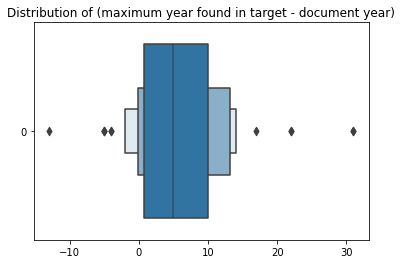

In [7]:
display(df[df['_contains_year']].groupby('_max_year_ge_doc_created').count()["Document ID"])

sns.boxenplot(data=df['_max_year'] - df["Date of Event"], orient="h").set_title("Distribution of (maximum year found in target - document year)");

### 2.3 figures that aren't years

> most targets contain a numerical non-year value (date, cardinal, quantity or percent) - there are some false negatives in this count too

In [8]:
ent_types = ("DATE", "CARDINAL", "QUANTITY", "PERCENT", "ORDINAL")

ent_col_names = []
ent_bool_col_names = []

for idx, row in df.iterrows():
    doc = nlp(row["Target Description"])
    
    for ent_type in ent_types:
        # exclude years
        ent_vals = [ent.text for ent in doc.ents if ent.label_ == ent_type if not get_years(ent.text)]
        
        col_name = f"_ents_{ent_type.lower()}"
        ent_col_names.append(col_name)
        df.at[idx, col_name] = ent_vals or np.nan
        
    df.at[idx, "_n_sentences"] = len(list(doc.sents))
    
for ent_type in ent_types:
    boolean_col_name = f'_contains_{ent_type.lower()}_ent'
    ent_bool_col_names.append(boolean_col_name)
    
    df[boolean_col_name] = df[f'_ents_{ent_type.lower()}'].notnull()
    display(df.groupby(boolean_col_name).count()["Document ID"])
    
# maximum and minimum
print("------------------------------")
for v in ("minimum", "maximum"):
    bool_col = f'_contains_{v}'
    df[bool_col] = df['Target Description'].apply(lambda i: v in i.lower())

    display(df.groupby(bool_col).count()["Document ID"])

_contains_date_ent
False    203
True      25
Name: Document ID, dtype: int64

_contains_cardinal_ent
False    119
True     109
Name: Document ID, dtype: int64

_contains_quantity_ent
False    219
True       9
Name: Document ID, dtype: int64

_contains_percent_ent
False    154
True      74
Name: Document ID, dtype: int64

_contains_ordinal_ent
False    220
True       8
Name: Document ID, dtype: int64

------------------------------


_contains_minimum
False    220
True       8
Name: Document ID, dtype: int64

_contains_maximum
False    227
True       1
Name: Document ID, dtype: int64

> targets that contain combinations of numerical entities are most likely to contain a combination of cardinal and date figures, followed by percent and date figures.

<AxesSubplot:>

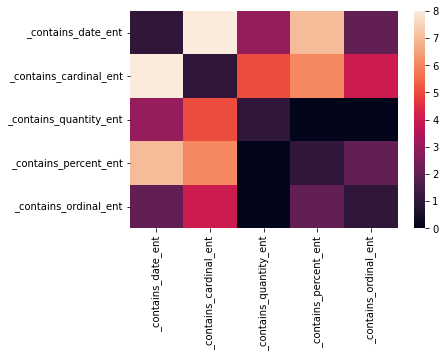

In [9]:
sns.heatmap(df[ent_bool_col_names].corr(method=np.dot))

> most of the non-year dates talk mention 'annual(ly)' or 'n years'

In [10]:
sorted(df.loc[df['_contains_date_ent'], "_ents_date"].sum())

['15 years',
 '5 years',
 '5 years',
 '5 years',
 '80 years',
 'Annually',
 'Five Year Plan',
 'Monthly',
 'The target year',
 'a year',
 'annual',
 'annual',
 'annual',
 'annually',
 'annually',
 'close to 80 years',
 'five years',
 'five-year',
 'five-year',
 'the 75th year',
 'the current year',
 'the end of the',
 'the next 5 years',
 'the next five years',
 'the next five years',
 'the next five years',
 'today']

### 2.4 Number of sentences

> most targets are 1 sentence long

In [11]:
df.groupby(["_n_sentences"]).count()["Document ID"]

_n_sentences
1.0    207
2.0     19
3.0      2
Name: Document ID, dtype: int64

> *"Construction of perinatal center in Bishkek funded by the German Government"* target seems to be lacking context?

In [12]:
# some targets with 3 or 2 sentences
df.sort_values('_n_sentences', ascending=False).head(5)[[col for col in df.columns if not col.startswith("_")]]

,Target ID,Document ID,Country Name,GHG/NON-GHG,Sector,Target Scope,Target Type,Is Target Per Capita?,Target Description,Target Page Number,Date of Event
189,167,9532,Bhutan,GHG,Economy-wide,Carbon neutrality,Fixed level target,No,"Carbon Neutral Declaration: The “Declaration of the Kingdom of Bhutan - The Land of Gross National Happiness to Save our Planet” made by the Kingdom of Bhutan in 2009 and reaffirmed in 2015 is a unilateral declaration and may have the status of international customary law. Therefore, as far as the obligations of Bhutan are concerned; the commitment to ensure GHG emissions remain below forest sinks must be fulfilled.",10,2020
81,66,10368,Kyrgyzstan,Non-GHG,Health,Health services,Fixed level target,No,Construction of perinatal center in Bishkek funded by the German Government. ✓ Construction of neurosurgical center of the National Hospital of the Ministry of Health of the Kyrgyz Republic. ✓ Construction of the surgical building of the city children’s clinical emergency hospital.,112,2018
20,17,9217,India,Non-GHG,Public sector,Public sector,Fixed level target,No,"18 new Indian diplomatic Missions in Africa approved in March, 2018, out of which 5 already opened. Another 4 new Embassies intended in 2019-20.",13,2019
173,152,4815 part 1,Sri Lanka,Non-GHG,Energy,Renewable energy,Fixed level target,No,The Government will endeavour to reach a minimum level of 10% of electrical energy supplied to the grid to be from NRE by a process of facilitation including access to green funding such as CDM. The target year to reach this level of NRE penetration is 2015.,10,2008
170,149,4815 part 2,Sri Lanka,Non-GHG,Transport,Electric vehicles,Fixed level target,No,At least 20% of all new light vehicle registrations shall be electric vehicles in 2022. At least 25 new public electric vehicle charging stations with DC rapid charging capability will be established at strategic locations by the CEB/LECO by 2020.,19,2019


### 2.5 common ngrams

In [50]:
import string
import random
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# input the reuters sentences
sents = df['Target Description'].tolist()
 
# write the removal characters such as : Stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation + '"' + '-' + "'" +'–' + "'"

tokens_remove = list(stop_words) + list(punctuation)
 
# remove stopwords & punctuation
processed_sents = []

for sent in sents:
    processed_sents.append(
        " ".join([tok for tok in word_tokenize(sent) if tok not in tokens_remove])
    )

# create lists of ngrams
unigrams = []
bigrams = []
trigrams = []

for sentence in processed_sents:
    sent_split = sentence.lower().split()
    
    unigrams.extend(sent_split)
    bigrams.extend(ngrams(
        sent_split, 
        2, 
        pad_left=False, 
        pad_right=False,
    ))
    trigrams.extend(ngrams(
        sent_split, 
        3, 
        pad_left=False, 
        pad_right=False
    ))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


> the most common ngrams seem to be overfitting to the longest document in the dataset

In [52]:
print("unigrams")
display(Counter(unigrams).most_common(10))

print("\nbigrams")
display(Counter(bigrams).most_common(10))

print("\ntrigrams")
display(Counter(trigrams).most_common(10))


unigrams


[('energy', 59),
 ('✓', 49),
 ('the', 41),
 ('new', 31),
 ('water', 27),
 ('2030', 23),
 ('centers', 23),
 ('hectares', 21),
 ('20', 21),
 ('reduction', 21)]


bigrams


[(('energy', 'consumption'), 16),
 (('water', 'supply'), 13),
 (('specific', 'energy'), 13),
 (('drinking', 'water'), 12),
 (('✓', 'construction'), 12),
 (('✓', 'modernization'), 12),
 (('modern', 'equipment'), 12),
 (('irrigated', 'land'), 11),
 (('thousand', 'hectares'), 10),
 (('new', 'irrigated'), 9)]


trigrams


[(('new', 'irrigated', 'land'), 9),
 (('hectares', 'new', 'irrigated'), 8),
 (('specific', 'energy', 'consumption'), 8),
 (('family', 'medicine', 'centers'), 7),
 (('social', 'assistance', 'centers'), 7),
 (('assistance', 'centers', 'disadvantaged'), 7),
 (('centers', 'disadvantaged', 'families'), 7),
 (('disadvantaged', 'families', 'children'), 7),
 (('families', 'children', 'centers'), 7),
 (('children', 'centers', 'responsible'), 7)]

#### ngrams containing years

In [53]:
bigrams_with_year = [g for g in bigrams if any([re.match(r"\d{4}", word) for word in g])]
trigrams_with_year = [g for g in trigrams if any([re.match(r"\d{4}", word) for word in g])]

> the informative trigrams (*2015 baseline*, *2030 relative*) once again seem to come from the same set of targets

In [58]:
print("bigrams containing year")
display(Counter(bigrams_with_year).most_common(10))

print("\ntrigrams containing year")
display(Counter(trigrams_with_year).most_common(10))

bigrams containing year


[(('relative', '2015'), 6),
 (('2015', 'baseline'), 6),
 (('2030', 'relative'), 5),
 (('by', '2023'), 4),
 (('20', '2030'), 4),
 (('set', '2019-20'), 3),
 (('end', '2023'), 3),
 (('2015', 'level'), 3),
 (('10', '2022'), 3),
 (('set', '2019-2020'), 2)]


trigrams containing year


[(('relative', '2015', 'baseline'), 6),
 (('2030', 'relative', '2015'), 5),
 (('corporation', 'set', '2019-2020'), 2),
 (('rural', 'households', '2024'), 2),
 (('new', 'clusters', '2019-20'), 2),
 (('incubators', 'tbis', '2019-20'), 2),
 (('tbis', '2019-20', 'develop'), 2),
 (('2019-20', 'develop', '75,000'), 2),
 (('11.6', 'end', '2023'), 2),
 (('value', 'chains', '2050'), 2)]